# HP Grid Search

In [37]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from deton8.utils import NucleiDataset
from deton8.pipeline import LinearPipeline

Using TensorFlow backend.


In [6]:
train = NucleiDataset("../data/stage1_train/").load()

In [7]:
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor

In [8]:
sgd_pipeline_params = {
    "regressor__regressor": SGDRegressor(penalty='elasticnet', l1_ratio=0.11, max_iter = 5, tol = None), 
    "regressor__batch_size": 1000,
    "regressor__num_iters": 50000,
}
pa_pipeline_params = {
    "regressor__regressor": PassiveAggressiveRegressor(C = .2, max_iter = 5, tol = None),
    "regressor__batch_size": 1000,
    "regressor__num_iters": 10000,
}

In [27]:
from tempfile import mkdtemp
sgd_memory = mkdtemp()
sgd_lp = LinearPipeline(memory=sgd_memory).set_params(**sgd_pipeline_params)
pa_memory = mkdtemp()
pa_lp = LinearPipeline(memory=pa_memory).set_params(**pa_pipeline_params)

In [28]:
sgd_lp.fit(train.images_, (train.masks_ > 0).astype(train.images_.dtype))

100%|██████████| 670/670 [00:17<00:00, 37.95pair/s]


Pipeline(memory='/tmp/tmph07a8jc9',
     steps=[('flattener', FunctionTransformer(accept_sparse=False,
          func=<function flatten_data at 0x7f00c9e8c158>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('whitener', PCA(copy=True, iterated_power='auto', n_components=1, ran...
          tqdm=<function MiniBatchRegressor.<lambda> at 0x7f00a366da60>,
          verbose=False))])

In [29]:
pa_lp.fit(train.images_, (train.masks_ > 0).astype(train.images_.dtype))

100%|██████████| 670/670 [00:17<00:00, 37.98pair/s]


Pipeline(memory='/tmp/tmpk2nvhabx',
     steps=[('flattener', FunctionTransformer(accept_sparse=False,
          func=<function flatten_data at 0x7f00c9e8c158>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('whitener', PCA(copy=True, iterated_power='auto', n_components=1, ran...
          tqdm=<function MiniBatchRegressor.<lambda> at 0x7f00a366da60>,
          verbose=False))])

In [30]:
from deton8.visualization import plot_grid

In [31]:
sgd_preds = sgd_lp.predict(train.images_)
pa_preds = pa_lp.predict(train.images_)

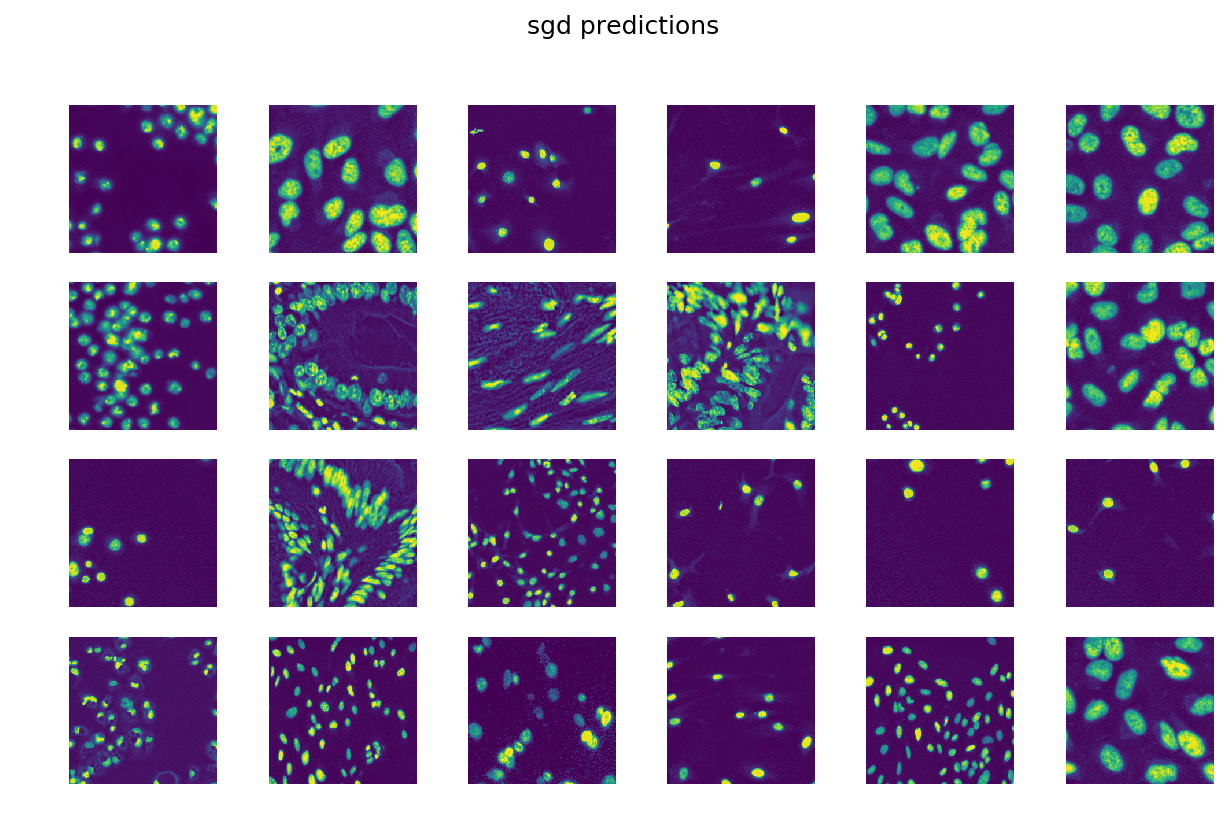

In [38]:
fig = plot_grid(sgd_preds[::10][:24], title="sgd predictions", gridsize=(4, 6))
plt.show()

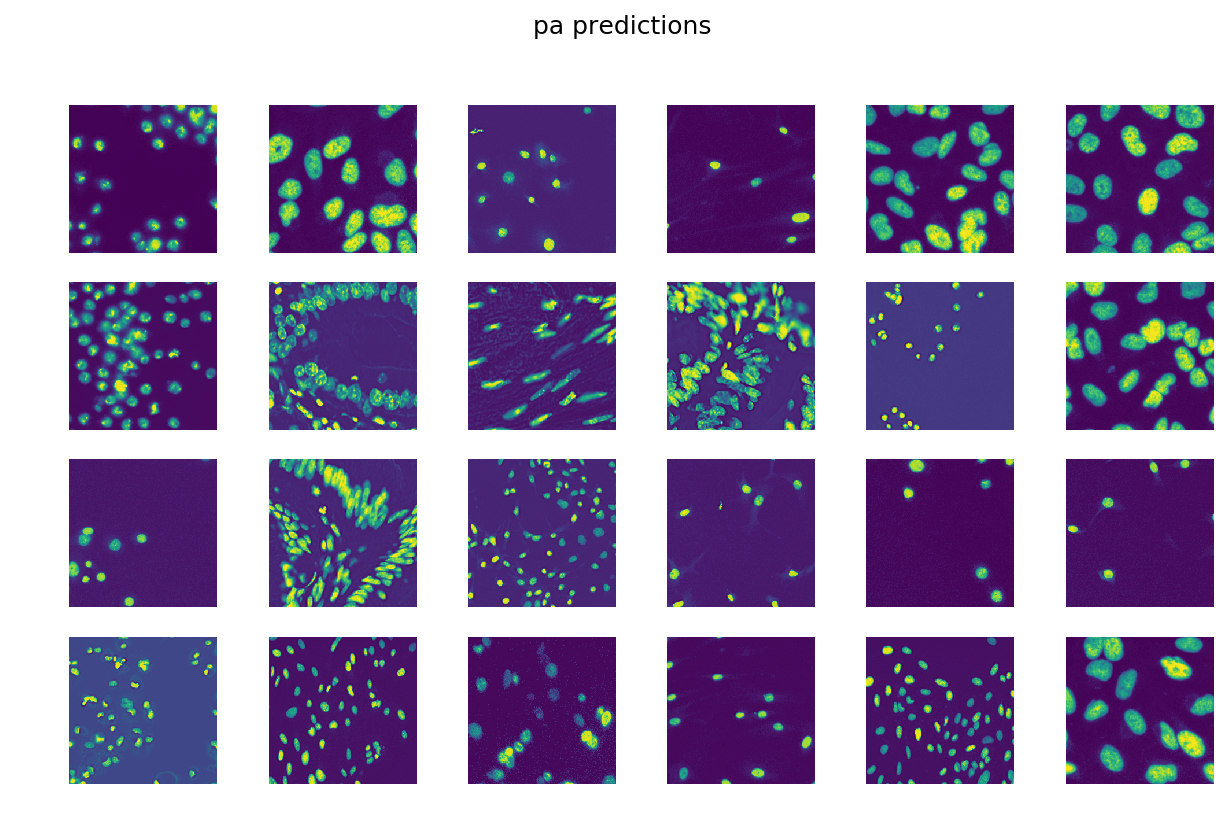

In [39]:
fig = plot_grid(pa_preds[::10][:24], title="pa predictions", gridsize=(4, 6))
plt.show()

In [41]:
from sklearn.externals import joblib

In [43]:
sgd_weights = sgd_lp.named_steps.regressor.regr_.coef_
pa_weights = pa_lp.named_steps.regressor.regr_.coef_

In [44]:
sgd_weights

array([-0.11803149, -0.02557403, -0.05413712,  1.16829001,  0.37140325,
       -0.0758354 ])

In [45]:
pa_weights

array([ 0.03261048,  0.05578575, -0.18817637,  1.59248049,  0.1386026 ,
       -0.48557777])

In [46]:
np.savez_compressed("../weights/linear_pipeline_regressor_weights.npz", sgd = sgd_weights, pa = pa_weights)

## UNet

### build features

In [53]:
from sklearn.model_selection import train_test_split

In [59]:
ytrain = (train.masks_ > 0).astype(train.images_.dtype)

In [64]:
xtransformed = sgd_lp.named_steps.basis_transformer.features_

In [68]:
xtransformed.shape

(670, 256, 256, 6)

In [69]:
sgd_preds.shape

(670, 256, 256)

In [70]:
pa_preds.shape

(670, 256, 256)

In [73]:
xtrain = np.concatenate((xtransformed, sgd_preds[:, :, :, None], pa_preds[:, :, :, None]), axis=3)

In [74]:
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, ytrain, train_size=0.7)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [76]:
xtrain.shape

(670, 256, 256, 8)

In [81]:
np.savez_compressed("../data/unet_features.npz", xtrain = xtrain, ytrain = ytrain)

### train

In [105]:
from deton8.unet import UNet
from keras.callbacks import ModelCheckpoint

In [106]:
chkpt = ModelCheckpoint(
    filepath="../weights/unet_weights.h5", 
    save_weights_only=True, 
    save_best_only=True,
    period=5)
steps_per_epoch = 25
epochs = 50
unet = UNet(numchannels=8, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[chkpt])

Unable to load saved weights.


In [ ]:
unet.fit(X_train,Y_train, X_val, Y_val)

Epoch 1/50


/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (468, 256, 256, 8) (8 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


25/25 [==============================] - 68s 3s/step - loss: -0.5202 - dice_coef: 0.5202 - mean_iou: 0.5443 - f1: 0.6522 - val_loss: -0.7199 - val_dice_coef: 0.7199 - val_mean_iou: 0.7407 - val_f1: 0.8341
Epoch 2/50
24/25 [===========================>..] - ETA: 2s - loss: -0.7208 - dice_coef: 0.7208 - mean_iou: 0.7808 - f1: 0.8334